# Transit Accessibility Factors

In [1]:
from pathlib import Path

import arcpy
from arcgis.features import GeoAccessor
import pandas as pd
from sklearn.preprocessing import minmax_scale

from gtfs_tools.gtfs import GtfsDataset
from gtfs_tools.utils.gtfs import add_modality_descriptions, calculate_headway

In [2]:
dir_prj = Path.cwd().parent
dir_data = dir_prj / 'data'

dir_raw = dir_data / 'raw'
dir_int = dir_data / 'interim'
dir_ext = dir_data / 'external'

gdb_int = dir_int / 'interim.gdb'
gdb_ext = dir_ext / 'external.gdb'

gtfs_parent_dir = dir_raw / 'gtfs_la_cbsa'

gtfs_factor_dir = dir_int / f'{gtfs_parent_dir.name}_factors.parquet'
gtfs_stops_dir = dir_int / f'{gtfs_parent_dir.name}_stops.parquet'

stops_fc = gdb_int / f'{gtfs_parent_dir.name}_stops'
poi_fc = gdb_ext / f'cbsa_la_h3_08_centroids'
poi_poly_fc = gdb_ext / f'cbsa_la_h3_08'

arcpy.env.overwriteOutput = True

## Assemble Trip Factor and Stops Data

In [3]:
gtfs_pth_lst = [pth.parent for pth in gtfs_parent_dir.glob('**/agency.txt')]

In [4]:
for gtfs_cache_dir in [gtfs_factor_dir, gtfs_stops_dir]:
    if not gtfs_cache_dir.exists():
        gtfs_cache_dir.mkdir(parents=True)

In [5]:
for gtfs_pth in gtfs_pth_lst:

    # create a gtfs dataset 
    gtfs = GtfsDataset(gtfs_pth, standardize_route_types=True)

    # build the parquet part output path
    factor_pth = gtfs_factor_dir / ("factors_mdb_" + gtfs.gtfs_folder.name.split("=")[1] + ".part")
    stops_pth = gtfs_stops_dir / ("stops_mdb_" + gtfs.gtfs_folder.name.split("=")[1] + ".part")

    #### LATE BY STOP ####

    # get the needed columns for calculating overnight service
    tm_df = gtfs.stop_times.data.loc[:,['stop_id', 'arrival_time']]

    # calculate hour of the day by getting the timedelta hours and retaining the remainder when dividing by 24
    tm_df['hours'] = tm_df['arrival_time'].dt.components.hours % 24

    # calculate late night by evaluating if the stop time is after an hour in the evening or before an hour in the morning
    tm_df['late_night'] = (tm_df['hours'] <= 3) | (tm_df['hours'] >= 23)

    # get just the overnight boolean
    late_df = tm_df[['stop_id', 'late_night']].drop_duplicates()

    ### HEADWAY ###
    headway_df = gtfs.stop_times.headway[['stop_id', 'headway']].groupby('stop_id').mean().rename(columns={'headway': 'stop_headway_mean'})

    ### FIXED ROUTE TYPE AND AGENCY ###

    # get data frame of stops, routes and route types
    rt_df = gtfs.routes.data.loc[:,['route_id', 'route_type', 'agency_id']].drop_duplicates()

    # add modality descriptions
    rt_df = add_modality_descriptions(rt_df)

    # add the agency name
    rt_df = rt_df.merge(gtfs.agency.data[['agency_id', 'agency_name']], on='agency_id')

    # flag fixed types (not bus or school bus)
    rt_df['fixed_modality'] = ~rt_df['route_type'].isin(['3', '31'])

    # add factor for each route; fixed routes are weighted 3x more than bus routes
    rt_df['modality_factor'] = rt_df['fixed_modality'].apply(lambda val: 1 if val else 1/3)

    # create the combined factor dataframe
    factor_df = (gtfs._crosstab_stop_trip
                 .merge(gtfs._crosstab_stop_route, on='stop_id')
                 .merge(rt_df, on='route_id')
                 .merge(late_df, on='stop_id')
                 .merge(headway_df, on='stop_id')
                 .drop(columns=['agency_id'])
                )

    # create stop, trip and route uid column using the agency name
    agency_root = factor_df['agency_name'].str.lower().str.findall(r'\w+').str.join('') + '_'
    factor_df['stop_uid'] = agency_root + factor_df['stop_id']
    factor_df['trip_uid'] = agency_root + factor_df['trip_id']
    factor_df['route_uid'] = agency_root + factor_df['route_id']

    #### SAVE OUTPUT ####
    factor_df.to_parquet(factor_pth)

    # create stops with uid
    stops_df = (gtfs.stops.sedf[['stop_id', 'stop_name', 'SHAPE']]
                .merge(gtfs._crosstab_stop_agency, on='stop_id')
                .merge(gtfs.agency.data[['agency_id', 'agency_name']], on='agency_id')
                .drop(columns='agency_id')
               )

    stops_df['stop_uid'] = stops_df['agency_name'].str.lower().str.findall(r'\w+').str.join('') + '_' + stops_df['stop_id']
    # save stops
    stops_df.spatial.to_parquet(stops_pth)
    
    break

In [7]:
gtfs.lookup_stop_trip.groupby('stop_id').nunique()

AttributeError: 'GtfsDataset' object has no attribute 'lookup_stop_trip'

In [66]:
# bulk load stops, set geometry and write to a feature class for geoprocessing
stops_df = pd.concat(GeoAccessor.from_parquet(pqt_pth) for pqt_pth in gtfs_stops_dir.glob('*.part'))
stops_df.spatial.set_geometry('SHAPE')

stops_df.spatial.to_featureclass(stops_fc)

'D:\\projects\\gtfs-tools\\data\\interim\\interim.gdb\\gtfs_la_cbsa_stops'

In [36]:
zip_pth = r"D:\projects\GTFS-Publishing\data\raw\StLouis_Metro_stlouisgtfszip_2024-06-04_00_00\STLouis_GTFS.zip"

In [3]:
gtfs = GtfsDataset.from_zip(zip_pth, standardize_route_types=True)

gtfs

GtfsDataset: C:\Users\joel5174\AppData\Local\Temp\tmp4g5f4gab

## Factors

## Quality of Service

### Weekly Trip Count per Stop

In [4]:
gtfs.stops.trip_count

,trip_count
stop_id,
10030,64
10031,64
10032,64
10033,64
10035,64
...,...
9920,63
9971,62
9972,62


### Headway

Headway is the amount of time spent waiting at a stop. For a single stop, this metric can be summarized using the mean (average).

In [9]:
gtfs.stop_times.headway

,stop_id,headway
124956,10030,16.0
121667,10030,24.0
124774,10030,38.0
121758,10030,4.0
121485,10030,40.0
...,...,...
122492,9974,1.0
127125,9974,59.0
122580,9974,1.0
126949,9974,59.0


In [5]:
headway_mean_df = gtfs.stop_times.headway.groupby('stop_id').mean().rename(columns={'headway': 'headway_mean'})

headway_mean_df

,headway_mean
stop_id,
10030,28.025641
10031,28.025641
10032,28.025641
10033,28.025641
10035,28.025641
...,...
9920,25.000000
9971,25.809524
9972,25.809524


### Overnight Service

Service after 11:00pm (2300) and before 3:00am (0300).

In [10]:
# get the needed columns for calculating overnight service
tm_df = gtfs.stop_times.data.loc[:,['stop_id', 'arrival_time']]

# calculate hour of the day by getting the timedelta hours and retaining the remainder when dividing by 24
tm_df['hours'] = tm_df['arrival_time'].dt.components.hours % 24

# calculate late night by evaluating if the stop time is after an hour in the evening or before an hour in the morning
tm_df['late_night'] = (tm_df['hours'] <= 3) | (tm_df['hours'] >= 23)

tm_df.info()
tm_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451318 entries, 0 to 451317
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype          
---  ------        --------------   -----          
 0   stop_id       451318 non-null  object         
 1   arrival_time  451318 non-null  timedelta64[ns]
 2   hours         451318 non-null  int64          
 3   late_night    451318 non-null  bool           
dtypes: bool(1), int64(1), object(1), timedelta64[ns](1)
memory usage: 10.8+ MB


,stop_id,arrival_time,hours,late_night
0,14818,0 days 13:50:00,13,False
1,15018,0 days 13:51:00,13,False
2,2732,0 days 13:52:00,13,False
3,14484,0 days 13:54:00,13,False
4,2638,0 days 13:54:00,13,False


In [33]:
late_df = tm_df[tm_df['late_night']]
late_hw_df = calculate_headway(late_df)
late_hw_mean_df = late_hw_df.groupby('stop_id').mean().rename(columns={'headway': 'late_headway_mean'})
late_hw_count_df = late_df[['stop_id', 'arrival_time']].groupby('stop_id').count().rename(columns={'arrival_time': 'late_trip_count'})

late_headway_df = late_hw_mean_df.join(late_hw_count_df)

late_headway_df

,late_headway_mean,late_trip_count
stop_id,,
10092,2.000000,3
10137,20.000000,9
10139,20.000000,9
10141,20.000000,9
10143,20.000000,9
...,...,...
9785,60.000000,6
9786,60.000000,6
9912,27.500000,11


In [35]:
# consolidate by stop to determine if the stop offers late night service
late_df = tm_df[['stop_id', 'late_night']].groupby('stop_id').any()

late_df.info()
late_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 5109 entries, 10030 to 9974
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   late_night  5109 non-null   bool 
dtypes: bool(1)
memory usage: 44.9+ KB


,late_night
stop_id,
10030,False
10031,False
10032,False
10033,False
10035,False


In [36]:
late_df.value_counts()

late_night
True          3153
False         1956
Name: count, dtype: int64

### Variety: Weighted Unique Routes

Weekly route count with fixed routes (not bus or school bus) weighted three times greater than standard routes.

In [37]:
# get data frame of stops, routes and route types
rt_df = pd.merge(gtfs._crosstab_stop_route, gtfs.routes.data.loc[:,['route_id', 'route_type']], on='route_id', how='left')

rt_df.info()
rt_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5800 entries, 0 to 5799
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   stop_id     5800 non-null   object
 1   route_id    5800 non-null   object
 2   route_type  5800 non-null   object
dtypes: object(3)
memory usage: 136.1+ KB


,stop_id,route_id,route_type
0,14818,18782,3
1,15018,18782,3
2,2732,18782,3
3,14484,18782,3
4,2638,18782,3


In [38]:
# flag fixed types (not bus or school bus)
rt_df['fixed_typ'] = ~rt_df['route_type'].isin([3, 31])

rt_df.info()
rt_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5800 entries, 0 to 5799
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   stop_id     5800 non-null   object
 1   route_id    5800 non-null   object
 2   route_type  5800 non-null   object
 3   fixed_typ   5800 non-null   bool  
dtypes: bool(1), object(3)
memory usage: 141.7+ KB


,stop_id,route_id,route_type,fixed_typ
0,14818,18782,3,True
1,15018,18782,3,True
2,2732,18782,3,True
3,14484,18782,3,True
4,2638,18782,3,True


In [39]:
# add factor for each route; fixed routes are weighted 3x more than bus routes
rt_df['weighted_route_factor'] = rt_df['fixed_typ'].apply(lambda val: 3 if val else 1)

rt_df

,stop_id,route_id,route_type,fixed_typ,weighted_route_factor
0,14818,18782,3,True,3
1,15018,18782,3,True,3
2,2732,18782,3,True,3
3,14484,18782,3,True,3
4,2638,18782,3,True,3
...,...,...,...,...,...
5795,16252,18846,3,True,3
5796,16246,18846,3,True,3
5797,16253,18846,3,True,3
5798,15707,18864,3,True,3


In [40]:
# sum weighted route factor by stop
stop_rt_df = rt_df[['stop_id', 'weighted_route_factor']].groupby('stop_id').sum()

stop_rt_df.info()
stop_rt_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 5109 entries, 10030 to 9974
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   weighted_route_factor  5109 non-null   int64
dtypes: int64(1)
memory usage: 79.8+ KB


,weighted_route_factor
stop_id,
10030,3
10031,3
10032,3
10033,3
10035,3


## Factors Combined

In [45]:
factor_df = (gtfs.stops.trip_count
             .join(late_df, on='stop_id')
             .join(stop_rt_df, on='stop_id')
             .join(headway_df.drop(columns='count'), on='stop_id')
            )

factor_df.info()
factor_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 5109 entries, 10030 to 9974
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   trip_count             5109 non-null   int64  
 1   late_night             5109 non-null   bool   
 2   weighted_route_factor  5109 non-null   int64  
 3   mean                   5109 non-null   float64
 4   std                    5108 non-null   float64
 5   min                    5109 non-null   float64
 6   25%                    5109 non-null   float64
 7   50%                    5109 non-null   float64
 8   75%                    5109 non-null   float64
 9   max                    5109 non-null   float64
dtypes: bool(1), float64(7), int64(2)
memory usage: 533.2+ KB


,trip_count,late_night,weighted_route_factor,mean,std,min,25%,50%,75%,max
stop_id,,,,,,,,,,
10030,64,False,3,28.025641,17.463476,1.0,14.0,25.0,40.0,60.0
10031,64,False,3,28.025641,17.513134,1.0,14.5,25.0,40.0,60.0
10032,64,False,3,28.025641,17.463476,1.0,14.0,25.0,40.0,60.0
10033,64,False,3,28.025641,17.463476,1.0,14.0,25.0,40.0,60.0
10035,64,False,3,28.025641,17.513134,1.0,14.5,25.0,40.0,60.0


### Understanding Patterns

Although only a single dataset, once combined in a data frame, we can use descriptive statistics to get an idea of the data trends.

In [46]:
factor_df.describe()

,trip_count,weighted_route_factor,mean,std,min,25%,50%,75%,max
count,5109.000000,5109.000000,5109.000000,5108.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000
mean,88.248189,3.405755,30.354994,12.250963,12.926404,21.095077,31.227246,37.703416,53.915443
std,67.122947,1.398194,19.095119,11.476759,21.979106,22.475243,20.384913,19.029476,29.114857
min,2.000000,3.000000,2.650104,0.000000,1.000000,1.000000,1.000000,3.000000,12.000000
25%,57.000000,3.000000,17.647059,7.700740,1.000000,6.000000,19.000000,27.000000,40.000000
50%,74.000000,3.000000,25.062500,12.055397,2.000000,10.500000,25.000000,30.000000,59.000000
75%,105.000000,3.000000,38.760000,15.025231,10.000000,29.000000,50.000000,59.000000,60.000000
max,957.000000,24.000000,529.000000,252.275643,529.000000,529.000000,529.000000,529.000000,529.000000


https://towardsdatascience.com/statistics-in-python-collinearity-and-multicollinearity-4cc4dcd82b3f

In [47]:
import seaborn as sns

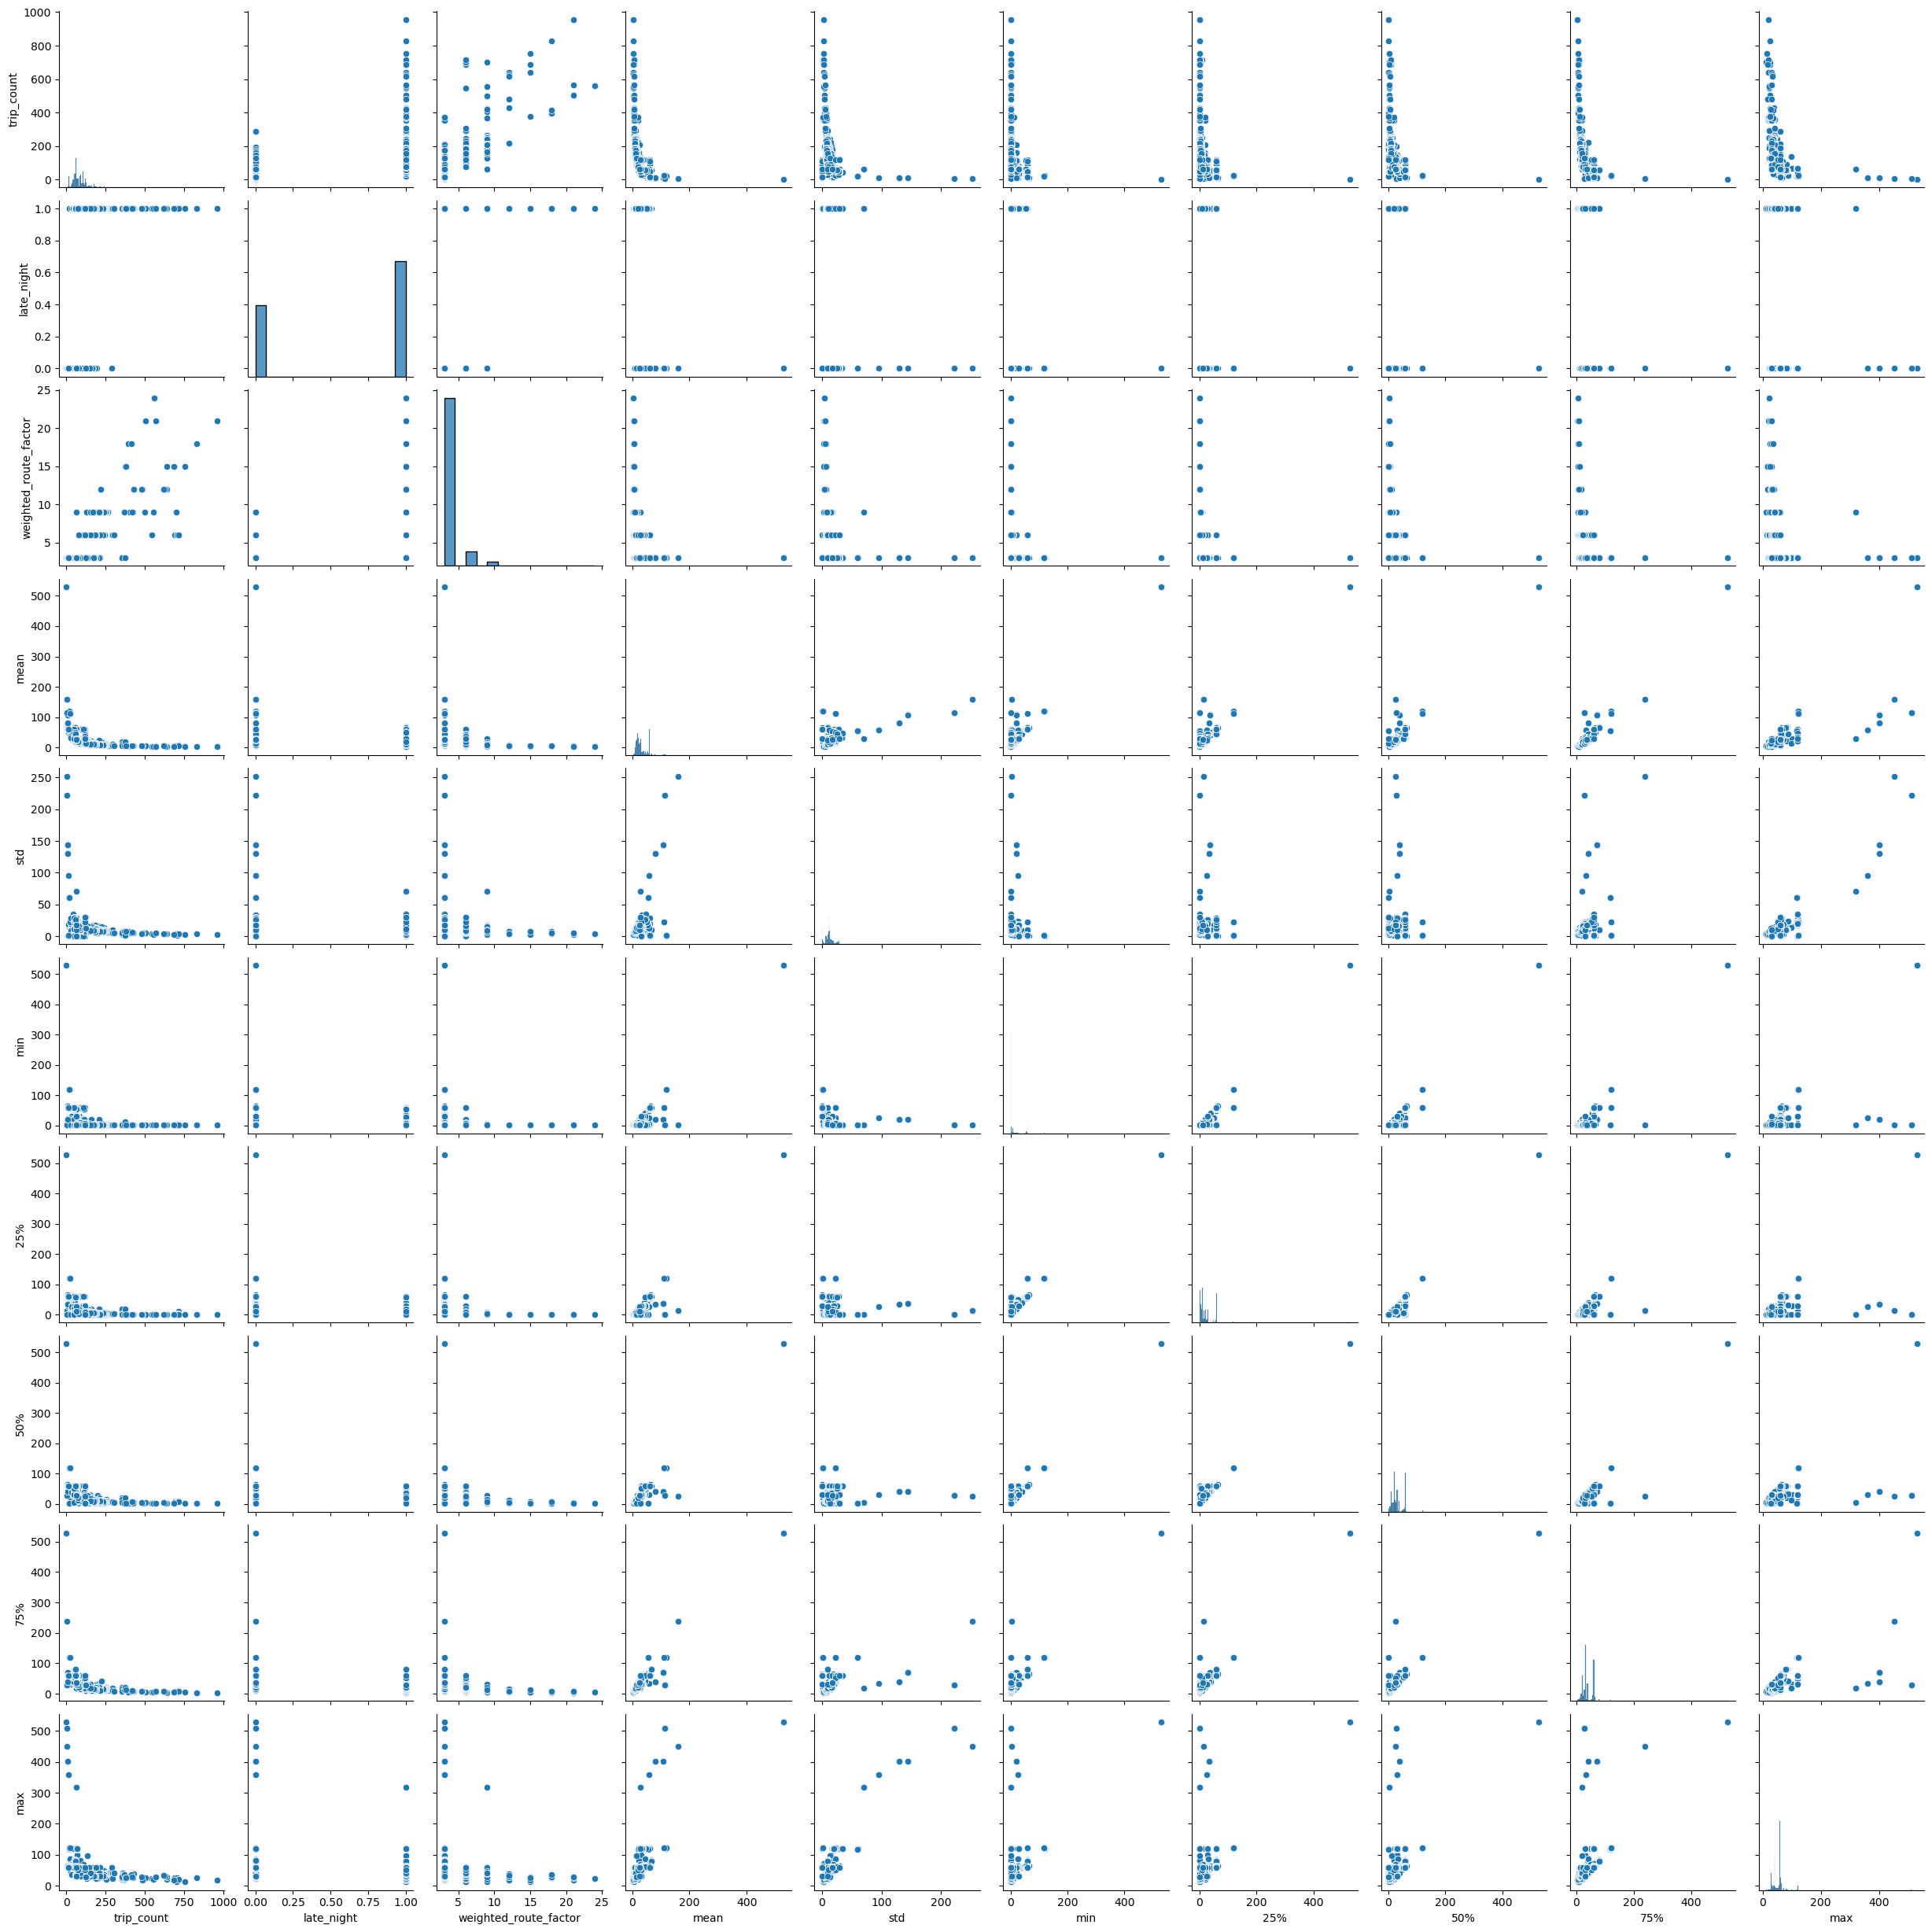

In [48]:
sns.pairplot(factor_df)